In [1]:
from sklearn.cluster import KMeans
import numpy as np
from time import time

In [2]:
def load_data():
    start = time()
    labels = np.loadtxt('data/csv_4/labels_lf.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    labels.shape = (-1,1)
    
    labels_l = np.loadtxt('data/csv_4/labels_l.csv', delimiter=',', dtype=np.float32)
    labels_l.shape = (-1,1)
    
    labels_f = np.loadtxt('data/csv_4/labels_f.csv', delimiter=',', dtype=np.float32)
    labels_f.shape = (-1,1)

    rgb = np.loadtxt('data/csv_4/rgbdata20.csv', delimiter=',', dtype=np.float32)
    rgb.shape = (-1, 3, 20, 20)
#     rgb = np.mean(rgb, axis=1)
    print('Job completed in: {} seconds'.format(time()-start))
    return rgb, labels, labels_l, labels_f

bw, labels, labels_l, labels_f = load_data()
nb_classes = 1
original_dim = 20
channels = 3
print('bw shape', bw.shape)
print('labels shape', labels.shape)

Job completed in: 13.346288919448853 seconds
bw shape (11564, 3, 20, 20)
labels shape (11564, 1)


In [4]:
def divide_data(bw, labels, labels_l, labels_f, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    bw = bw[mask]/255
    lf = np.minimum(labels[mask], 1.0)
    l = labels_l[mask]
    f = labels_f[mask]
    
    X_train = bw[:train_size]
    lf_train = lf[:train_size]
    l_train = l[:train_size]
    f_train = f[:train_size]
    
    X_test = bw[train_size:]
    lf_test = lf[train_size:]
    l_test = l[train_size:]
    f_test = f[train_size:]

    return (X_train, lf_train, l_train, f_train), (X_test, lf_test, l_test, f_test)

(X_train, lf_train, l_train, f_train), (X_test, lf_test, l_test, f_test) = divide_data(bw, labels, labels_l, labels_f,
#                                                    data_size=1000, 
                                                   train_ratio=10/11) # 10/11 this ratio allows train = 10*test
print('X_train shape:', X_train.shape)
print('lf_train shape:', lf_train.shape)

# print('X_train', X_train[:2])
# print('y_train', y_train[:2])

X_train shape: (10512, 3, 20, 20)
lf_train shape: (10512, 1)


In [5]:
X_train.shape = (-1, channels * original_dim**2)
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters,
                n_init=10,
                random_state=0)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

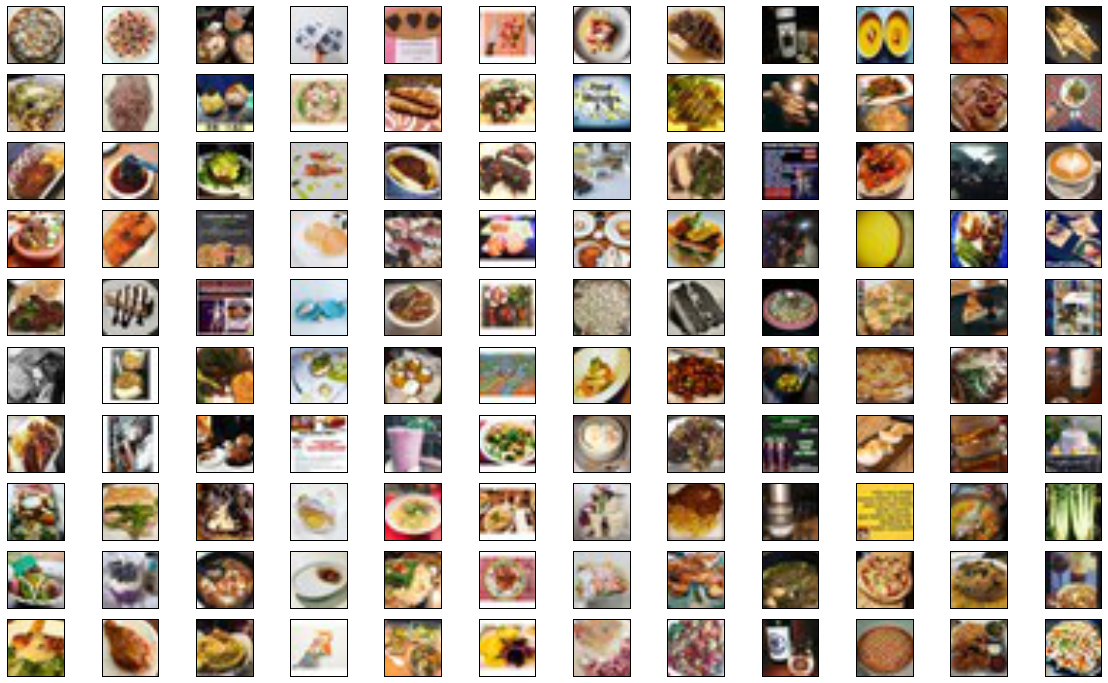

In [6]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10  # how many images to display per class

plt.figure(figsize=(20, n_clusters))

idx_list = [[] for i in range(n_clusters)] 
for k in range(len(kmeans.labels_)):
    idx_list[kmeans.labels_[k]].append(k)

for j in range(n_clusters):
    for i in range(n):
        ax = plt.subplot(n, n_clusters, j + 1 + n_clusters*i)
        k = idx_list[j][i]
        
        plt.imshow(np.transpose(X_train[k].reshape(channels, original_dim, original_dim),(1,2,0)))
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


plt.show()

In [7]:
X_train_list = [] # list of actual images
for i in range(n_clusters):
    class_ = idx_list[i]
    X_train_list.append(X_train[class_])
# print(np.array(X_train_list))

In [8]:
for class_ in idx_list:
    mean = sum(l_train[class_])/len(class_)
    print(mean)

[ 137.2615509]
[ 112.20847321]
[ 158.33656311]
[ 136.48352051]
[ 112.2194519]
[ 169.56872559]
[ 156.78874207]
[ 99.58306885]
[ 88.89964294]
[ 133.50712585]
[ 103.50662231]
[ 94.87963104]


[ -7.20429696e-10   1.18531493e-04   4.23641650e+00]


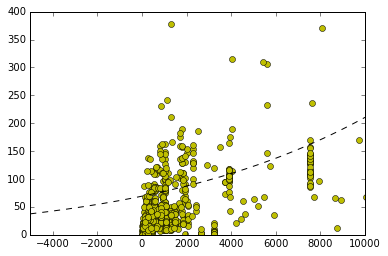

[ -2.44039037e-11   2.12708387e-05   4.90643960e+00]


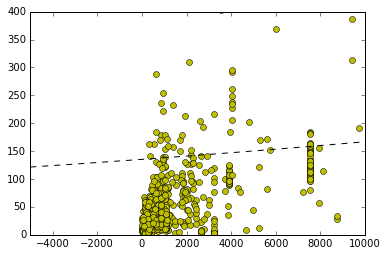

[ -1.76564345e-10   7.62626789e-05   4.75931169e+00]


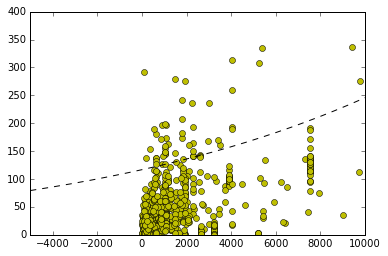

[ -8.06698968e-11   5.22477104e-05   4.88009527e+00]


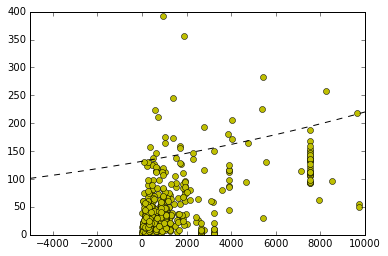

[ -6.32102442e-11   4.17292541e-05   5.00286361e+00]


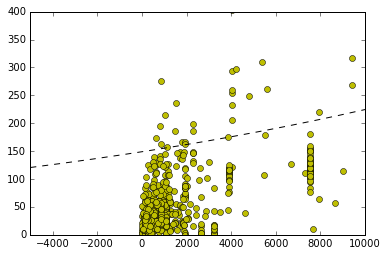

[ -7.21953584e-10   1.20912782e-04   4.27062827e+00]


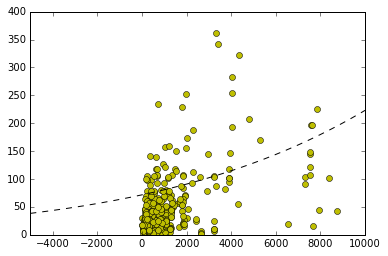

[ -6.23994199e-11   4.03310175e-05   5.24964181e+00]


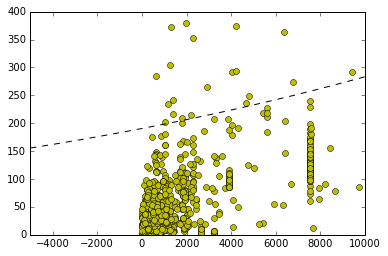

[ -2.00679035e-10   8.61080077e-05   4.34043240e+00]


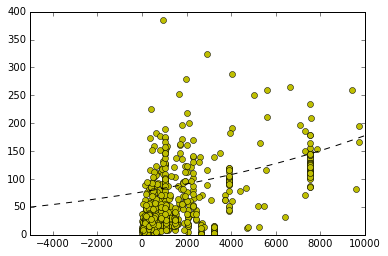

[ -1.18760369e-10   5.32521049e-05   4.58364669e+00]


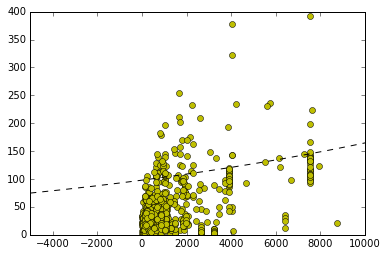

[ -7.86711870e-11   4.91533763e-05   5.14450593e+00]


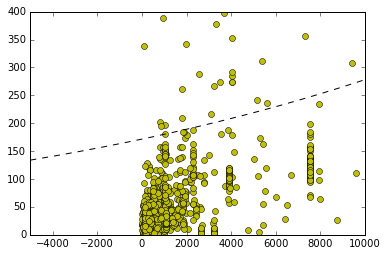

[ -1.09190004e-10   5.60436695e-05   4.75364935e+00]


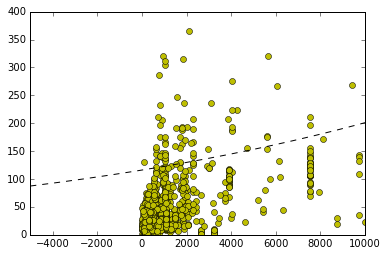

[ -8.32963127e-11   4.02751404e-05   4.84423678e+00]


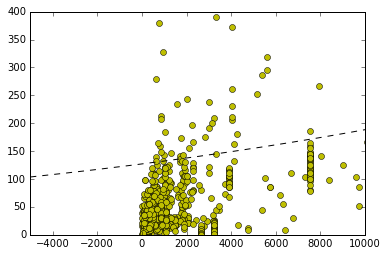

In [17]:
polyfit = []
for class_ in idx_list:
    xrange = (-5000,10000)
    yrange = (0, 400)
    x = np.reshape(f_train, (-1))[class_]
    y = np.reshape(l_train, (-1))[class_]
    fit = np.polyfit(x+0.0001,np.log(y+0.001),2, w=np.sqrt(y))
    print(fit)
    fit_fn = np.poly1d(fit) 
    polyfit.append(fit_fn)
    plt.plot(x, y, 'yo')
    x = list(range(*xrange))
    plt.plot(x, np.exp(fit_fn(x)), 'k--')
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()

In [12]:
for i in range(n_clusters):
    print('popularity for', i)
    print(200, np.exp(polyfit[i](200)))
    print(800, np.exp(polyfit[i](800)))
    print(3200, np.exp(polyfit[i](3200)))
    print(12800, np.exp(polyfit[i](12800)))

popularity for 0
200 70.8166382658
800 76.0035929423
3200 100.317491585
12800 280.222632224
popularity for 1
200 135.733416461
800 137.474803068
3200 144.641227815
12800 176.744996772
popularity for 2
200 118.457845792
800 123.990981649
3200 148.642522586
12800 300.830108053
popularity for 3
200 133.02559902
800 137.255178186
3200 155.471413959
12800 253.572303923
popularity for 4
200 150.085770081
800 153.885151932
3200 169.991757217
12800 251.298554991
popularity for 5
200 73.3162259302
800 78.7986957226
3200 104.601340633
12800 298.875473096
popularity for 6
200 192.040352383
800 196.736779267
3200 216.602114551
12800 315.972540922
popularity for 7
200 78.0731317882
800 82.2028827727
3200 100.879130401
12800 223.572477574
popularity for 8
200 98.9181126081
800 102.122428117
3200 115.912699969
12800 189.770592588
popularity for 9
200 173.180337062
800 178.355417212
3200 200.53547126
12800 317.595850229
popularity for 10
200 117.313954646
800 121.317903474
3200 138.638660605
12800 233

In [ ]:
print(kmeans.labels_)
X_test.shape = (-1, channels * original_dim**2)
print(kmeans.predict(X_test))
X_test, f_test, l_test

### Need to do

Plot a regression line from raw followers vs likes to show that our method is better (compare validation error)
Create function to calculate error for one point, mean error for the training set, and error for the val set
compare errors


In [ ]:
X_test.shape = (-1, channels * original_dim**2)
print(kmeans.predict(X_test))
X_test, y_test

plt.figure()
plt.imshow(np.transpose(X_test[k].reshape(channels, original_dim, original_dim),(1,2,0)))
plt.show()

for i in range(n_clusters):
    print(np.exp(polyfit[i](400)))